# Group Data Generation Example
For the group data generation, the probability to have a true positive label is dependent on the previous predictions of the whole group sharing the protected attribute. The group moves towards the positive cluster depending on the sum of positive predictions for the whole group. 

In [1]:
import sys
import numpy as np
sys.path.append("../")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

from ltf.ltf_plot import LongTermFairnessPlot
from ltf.ltf_data.group_data_generator import GroupDataGenerator
from ltf.ltf_metric.aif360_metric import AifLongTermMetric

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# The generator.
generator = GroupDataGenerator(mean_pos=[0, 1],
                               mean_neg=[12, 11],
                               num_positive_label=100,
                               num_negative_label=100,
                               discrimination_factor=.9)

In [4]:
# The helper class is necessary to use sklearn with the ltf framework.
class CLF:
    def __init__(self, clf=LogisticRegression()):
        self.c = clf
    def predict(self, X, X_s):
        return self.c.predict(X)
    def fit(self, X, X_s, y):
        self.c.fit(X, y)     

## 1. Unconstrained Example

In [5]:
# The long term metric with default options (disparate impact and accuracy).
metric = AifLongTermMetric()

In [6]:
# The clf, this time a linear support vector machine.
clf = CLF(LinearSVC())

In [7]:
# The plot generator.
l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 14], y_lim=[-1, 14])

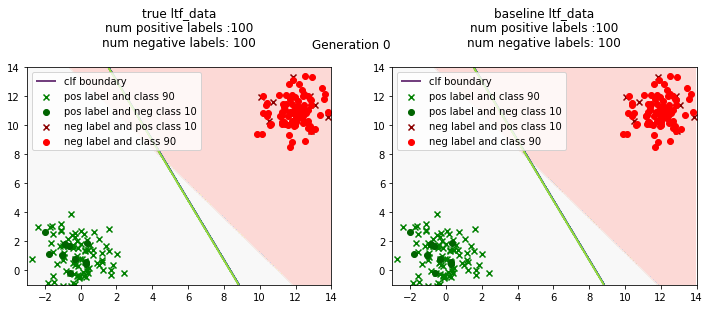

In [8]:
# Init the data and plot the first generation.
l.init_data()
l.plot_step()

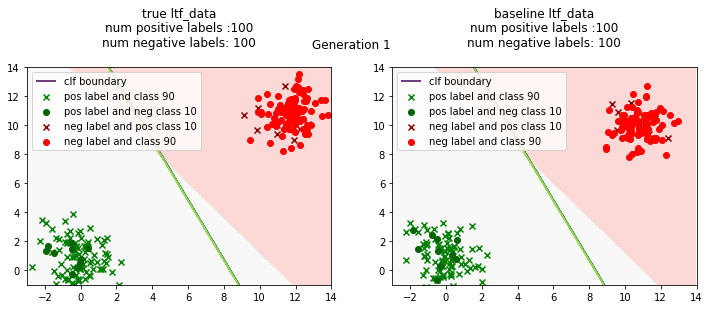

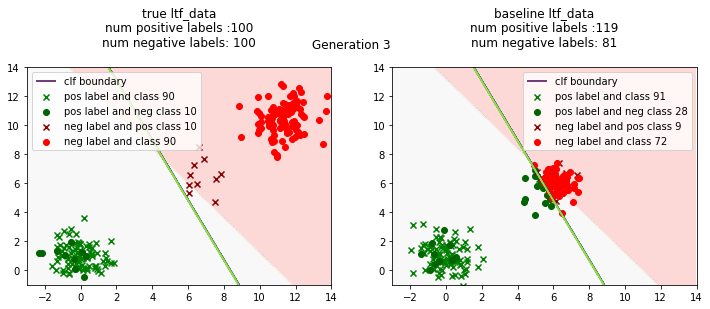

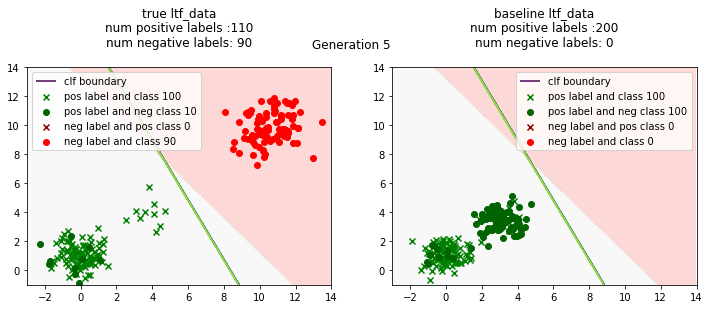

In [9]:
# Run six generations with clf updated after each step.
for i in range(6):

    l.run_step()
    l.run_baseline_step()
    if i % 2 == 0:
        l.plot_step()

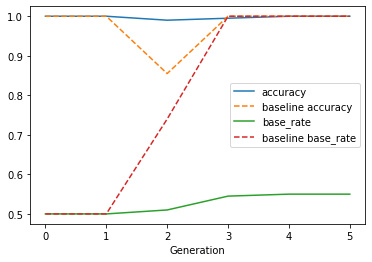

In [10]:
l.plot_ltf(metric._metrics)

The plot is similar to the one in the previous section. All points in the baseline pipeline moved towards the positive cluster. However, in the true data the base rate now also increases slowly.

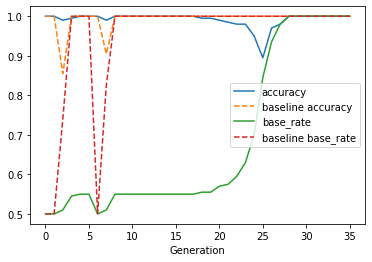

In [11]:
# Run 30 generations again.
l.run(30)
l.plot_ltf(metric._metrics)

Even in the unconstrained example, individuals from both pipelines move towards the positive cluster towards the end.

## 2. Constrained Example
The constrained example again uses the artificial decision rule.

In [12]:
# Fair artificial decision rule. The artificial decision rule is necessary, to produce the desired result...
class FairCLF:
    def predict(self, X, X_s):
        pred = [5, -13] @ X.T + 50
        
        pred[pred>0] = 1
        pred[pred<0] = 0
        
        return np.sign(pred)
    def fit(self, X, X_s, y):
        pass

In [13]:
# The artificial fair clf.
clf = FairCLF()

In [14]:
# The ltf plot.
l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 14], y_lim=[-1, 14])

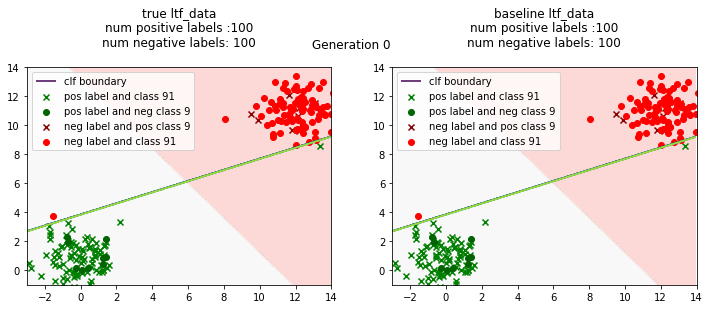

In [15]:
# Init and plot data.
l.init_data()
l.plot_step()

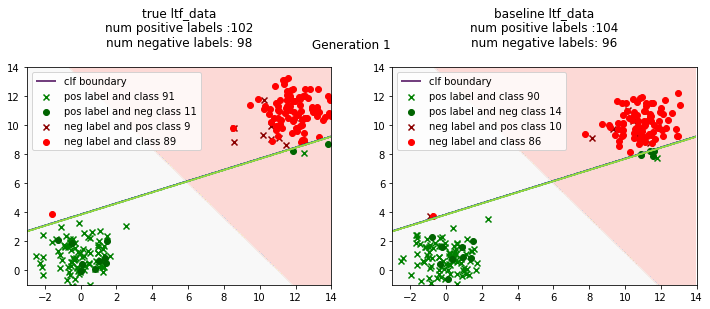

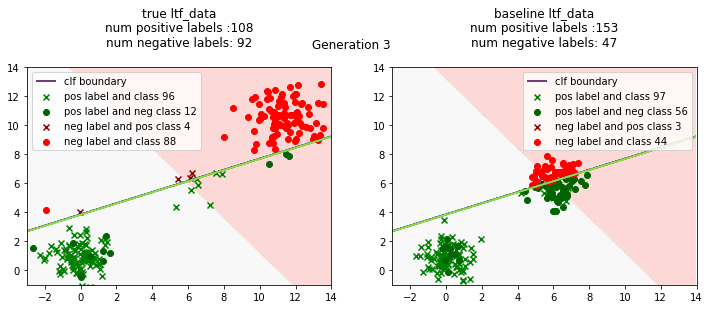

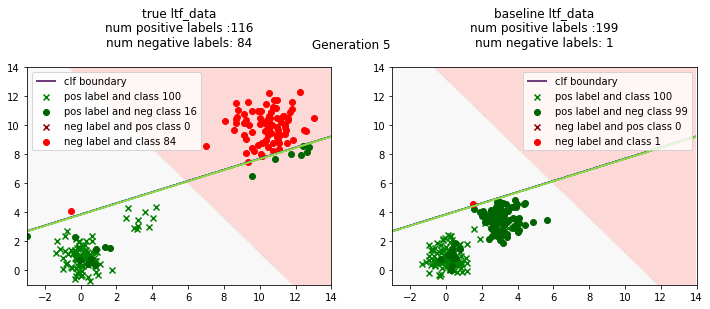

In [16]:
# Run six iterations.
for i in range(6):
    l.run_step()
    l.run_baseline_step()
    if i % 2 == 0:
        l.plot_step()

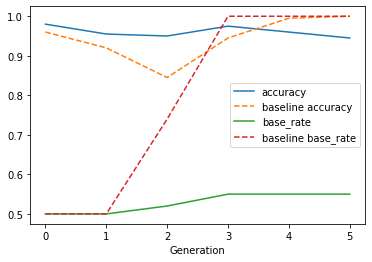

In [17]:
# Plot the results after 6 iterations.
l.plot_ltf(metric._metrics)

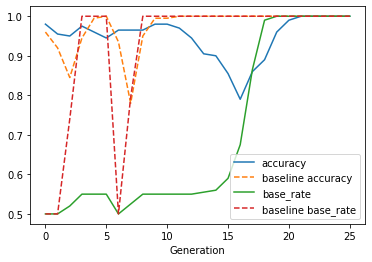

In [18]:
# Run another 20 iterations.
l.run(20)
l.plot_ltf(metric._metrics)

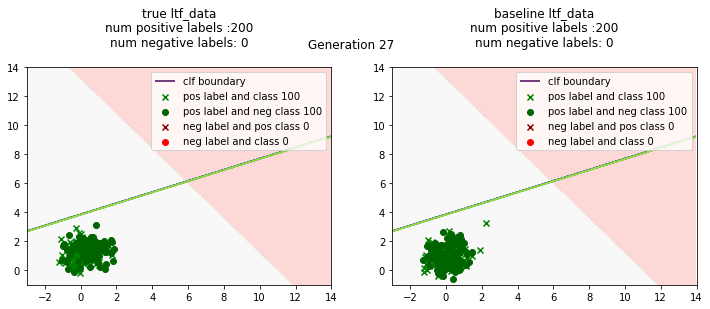

In [19]:
l.plot_step()

Again, all points are positive labeled after some time, due to the constrained decision function, this happens much faster now.

## 3. Conclusion
In this example, all individuals benefit from positive decisions in the same way. Therefore, the whole group slowly moves towards the positive cluster. It, however, takes very long since only a few individuals of the protected group have a positive label.